# Upendo - A gentle Introduction to RAG with Gemini and Langchains

### LangChain on Vertex AI (Preview) lets you use the LangChain open source library to build custom Generative AI applications and use Vertex AI for models, tools and deployment. With LangChain on Vertex AI (Preview), you can do the following:

1. Select the large language model (LLM) that you want to work with.
2. Define tools to access external APIs.
3. tructure the interface between the user and the system components in an orchestration framework.
4. Deploy the framework to a managed runtime.

Benefits

- Customizable: By utilizing LangChain's standardized interfaces, LangChain on Vertex AI can be adopted to build different kinds of applications. You can customize the logic of your application and incorporate any framework, providing a high degree of flexibility.
- Simplifies deployment: LangChain on Vertex AI uses the same APIs as LangChain to interact with LLMs and build applications. LangChain on Vertex AI simplifies and speeds up deployment with Vertex AI LLMs since the Reasoning Engine runtime supports single click deployment to generate compliant API based on your library.
- Integration with Vertex AI ecosystems: Reasoning Engine for LangChain on Vertex AI uses Vertex AI's infrastructure and prebuilt containers to help you deploy of your LLM application. You can use the Vertex AI API to integrate with Gemini models, Function Calling, and Extensions.
- Secure, private, and scalable: You can use a single SDK call instead of managing the development process on your own. The Reasoning Engine managed runtime frees you from tasks such as application server development, container creation, and configuration of authentication, IAM, and scaling. Vertex AI handles autoscaling, regional expansion, and container vulnerabilities.

## Step 1: Install and Import dependenciesInstall Libraries

In [1]:
!pip install --upgrade --user --quiet google-cloud-aiplatform

In [2]:
!pip install -U --quiet langchain langchain-chroma langchain-community openai langchain-experimental
!pip install --quiet "unstructured[all-docs]" pypdf pillow pydantic lxml pillow matplotlib chromadb tiktoken docling

In [10]:
!pip install -U --quiet langchain_google_vertexai

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-python-client 1.8.0 requires google-api-core<2dev,>=1.13.0, but you have google-api-core 2.22.0 which is incompatible.
kfp 2.5.0 requires kubernetes<27,>=8.0.0, but you have kubernetes 31.0.0 which is incompatible.
kfp 2.5.0 requires requests-toolbelt<1,>=0.8.0, but you have requests-toolbelt 1.0.0 which is incompatible.


In [34]:
!pip install --quiet langchain-chroma

In [3]:
# Restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [1]:
!gcloud config list

[compute]
region = us-central1
[core]
account = 534297186371-compute@developer.gserviceaccount.com
disable_usage_reporting = True
project = angelic-bee-193823
[dataproc]
region = us-central1

Your active configuration is: [default]


### Initialise Vertex AI platform

In [2]:
PROJECT_ID = "angelic-bee-193823"  
LOCATION = "us-central1"  

import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

## Step 2: Prepare and load data

### Docling Loaders

In [ ]:
# import os
# from docling.document_converter import DocumentConverter

# # Define the file path
# directory = "data"
# file_name = "Africa_Developer_Ecosystem_Report_2021.pdf"
# source = os.path.join(directory, file_name)

# # Print the absolute path for verification
# absolute_path = os.path.abspath(source)
# print("Looking for file at:", absolute_path)

# # Check if the file exists at the absolute path
# if os.path.isfile(absolute_path):
#     print("File found:", absolute_path)
    
#     # Initialize the converter and convert the document
#     converter = DocumentConverter()
    
#     try:
#         result = converter.convert(absolute_path)
#         # Print the document in markdown format
#         print(result.document.export_to_markdown())
#     except Exception as e:
#         print("An error occurred during conversion:", e)
# else:
#     print("File not found at:", absolute_path)
#     print("Please check if the file path and name are correct.")


#### Load the text content from the document

In [3]:
import os

# Define the file path
directory = "data"
file_name = "Africa_Developer_Ecosystem_Report_2021.pdf"
source = os.path.join(directory, file_name)

# Print the absolute path for verification
absolute_path = os.path.abspath(source)
print("Looking for file at:", absolute_path)

# Check if the file exists at the absolute path
if os.path.isfile(absolute_path):
    print("File found:", absolute_path)

Looking for file at: /home/jupyter/upendo/backend/data/Africa_Developer_Ecosystem_Report_2021.pdf
File found: /home/jupyter/upendo/backend/data/Africa_Developer_Ecosystem_Report_2021.pdf


In [4]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(absolute_path)
docs = loader.load()
tables = []
texts = [d.page_content for d in docs]

#### Check the content from the first page

In [7]:
texts[0]

'Africa \nDeveloper \nEcosystem\n2021 \nCreating opportunities and building \nfor the future \n'

#### Total pages in the document

In [8]:
len(texts)

68

## Step 3: Generate Text Summaries

#### Import required libraries first

In [20]:
from langchain_google_vertexai import VertexAI , ChatVertexAI , VertexAIEmbeddings
from langchain.prompts import PromptTemplate
from langchain_core.messages import AIMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda

#### Get Text Summaries

In [12]:
# Generate summaries of text elements
def generate_text_summaries(texts, tables, summarize_texts=False):
   """
   Summarize text elements
   texts: List of str
   tables: List of str
   summarize_texts: Bool to summarize texts
   """

   # Prompt
   prompt_text = """You are an assistant tasked with summarizing tables and text for retrieval. \
   These summaries will be embedded and used to retrieve the raw text or table elements. \
   Give a concise summary of the table or text that is well optimized for retrieval. Table or text: {element} """
   prompt = PromptTemplate.from_template(prompt_text)
   empty_response = RunnableLambda(
       lambda x: AIMessage(content="Error processing document")
   )
   # Text summary chain
   model = VertexAI(
       temperature=0, model_name="gemini-pro", max_output_tokens=1024
   ).with_fallbacks([empty_response])
   summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

   # Initialize empty summaries
   text_summaries = []
   table_summaries = []

   # Apply to text if texts are provided and summarization is requested
   if texts and summarize_texts:
       text_summaries = summarize_chain.batch(texts, {"max_concurrency": 1})
   elif texts:
       text_summaries = texts

   # Apply to tables if tables are provided
   if tables:
       table_summaries = summarize_chain.batch(tables, {"max_concurrency": 1})

   return text_summaries, table_summaries


# Get text summaries
text_summaries, table_summaries = generate_text_summaries(
   texts, tables, summarize_texts=True
)

text_summaries[0]

'## Africa Developer Ecosystem 2021: Creating Opportunities and Building for the Future\n\nThis report highlights the growth and potential of the African developer ecosystem in 2021. Key takeaways include:\n\n* **Opportunities:** The report identifies several opportunities for developers in Africa, including the rise of the digital economy, increased access to technology, and a growing demand for tech talent.\n* **Building for the future:** The report emphasizes the importance of building a strong foundation for the African developer ecosystem, including investing in education and training, fostering collaboration, and creating an enabling environment for innovation.\n* **Key trends:** The report identifies several key trends in the African developer ecosystem, such as the growth of mobile development, the rise of open source, and the increasing adoption of cloud computing.\n\nThis report is a valuable resource for anyone interested in the African developer ecosystem, including develop

## Step 4: Generate Image Summaries

In [21]:
import requests
from IPython.display import Image

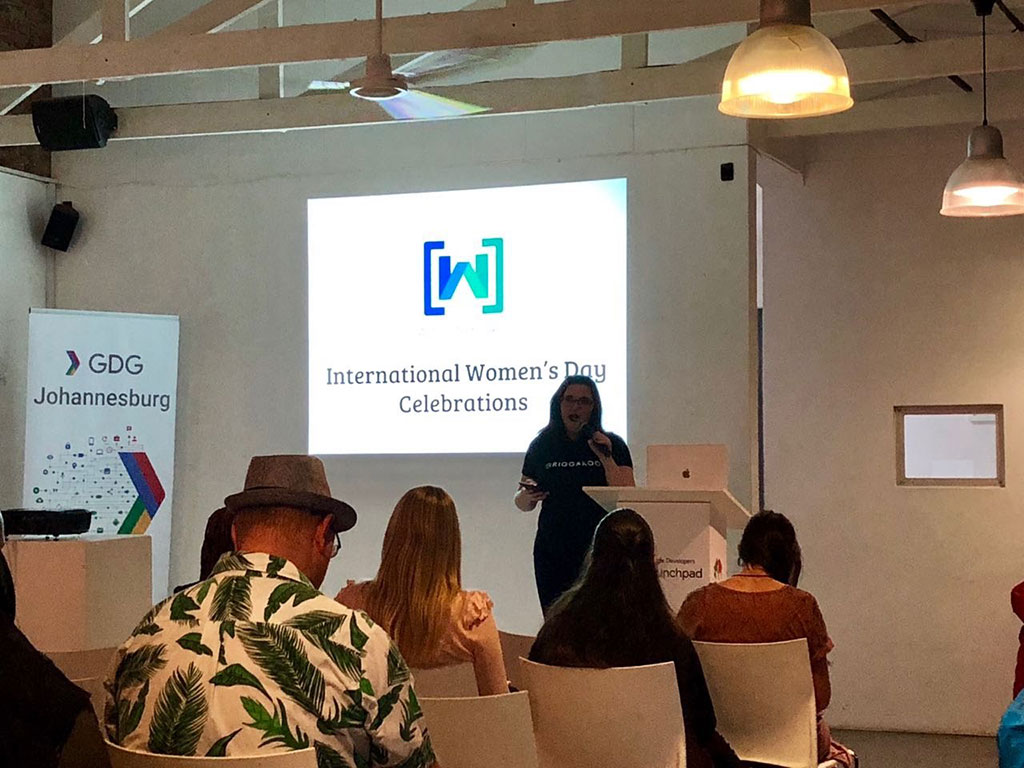

In [22]:
image_url = "https://www.dvt.co.za/images/gallery/gdg-johannesburg-meetup-iwd-women-techmakers-talks-4-april-gauteng/02.jpg"
content = requests.get(image_url).content
Image(content)

#### Import required libraries

In [23]:
import base64
import os

from langchain_core.messages import HumanMessage

#### Generate Image Summaries

In [17]:
# # Fetch the image content
# response = requests.get(image_url)
# content = response.content

# # Convert the image content to base64
# img_base64 = base64.b64encode(content).decode("utf-8")

In [ ]:
# def encode_image(image_path):
#    """Getting the base64 string"""
#    with open(image_path, "rb") as image_file:
#        return base64.b64encode(image_file.read()).decode("utf-8")


# def image_summarize(img_base64, prompt):
#    """Make image summary"""
#    model = ChatVertexAI(model_name="gemini-pro-vision", max_output_tokens=1024)

#    msg = model(
#        [
#            HumanMessage(
#                content=[
#                    {"type": "text", "text": prompt},
#                    {
#                        "type": "image_url",
#                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
#                    },
#                ]
#            )
#        ]
#    )
#    return msg.content


# def generate_img_summaries(path):
#    """
#    Generate summaries and base64 encoded strings for images
#    path: Path to list of .jpg files extracted by Unstructured
#    """

#    # Store base64 encoded images
#    img_base64_list = []

#    # Store image summaries
#    image_summaries = []

#    # Prompt
#    prompt = """You are an assistant tasked with summarizing images for retrieval. \
#    These summaries will be embedded and used to retrieve the raw image. \
#    Give a concise summary of the image that is well optimized for retrieval."""

#    # Apply to images
#    for img_file in sorted(os.listdir(path)):
#        if img_file.endswith(".jpg"):
#            img_path = os.path.join(path, img_file)
#            base64_image = encode_image(img_path)
#            img_base64_list.append(base64_image)
#            image_summaries.append(image_summarize(base64_image, prompt))

#    return img_base64_list, image_summaries


# # Image summaries
# img_base64_list, image_summaries = generate_img_summaries("./cj")

# len(img_base64_list)

# len(image_summaries)

# image_summaries[0]

## Step 5: Build Multi-Vector Retrieval

In [31]:
import uuid
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document

#### Create Multi-Vector Retrieval

In [35]:
def create_multi_vector_retriever(
   vectorstore, text_summaries, texts, table_summaries, tables
):
   """
   Create retriever that indexes summaries
   """

   # Initialize the storage layer
   store = InMemoryStore()
   id_key = "doc_id"

   # Create the multi-vector retriever
   retriever = MultiVectorRetriever(
       vectorstore=vectorstore,
       docstore=store,
       id_key=id_key,
   )

   # Helper function to add documents to the vectorstore and docstore
   def add_documents(retriever, doc_summaries, doc_contents):
       doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
       summary_docs = [
           Document(page_content=s, metadata={id_key: doc_ids[i]})
           for i, s in enumerate(doc_summaries)
       ]
       retriever.vectorstore.add_documents(summary_docs)
       retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

   # Add texts, tables, and images
   # Check that text_summaries is not empty before adding
   if text_summaries:
       add_documents(retriever, text_summaries, texts)
   # Check that table_summaries is not empty before adding
   if table_summaries:
       add_documents(retriever, table_summaries, tables)

   return retriever


# The vectorstore to use to index the summaries
vectorstore = Chroma(
   collection_name="mm_rag_cj_blog",
   embedding_function=VertexAIEmbeddings(model_name="textembedding-gecko@latest"),
)

# Create retriever
retriever_multi_vector_img = create_multi_vector_retriever(
   vectorstore,
   text_summaries,
   texts,
   table_summaries,
   tables
)
 

## Step 6: Building Multi-Modal RAG

In [36]:
def multi_modal_rag_chain(retriever):
   """
   Multi-modal RAG chain
   """

   # Multi-modal LLM
   model = ChatVertexAI(
       temperature=0, model_name="gemini-pro-vision", max_output_tokens=1024
   )

   # RAG pipeline
   chain = (
       {
           "context": retriever | RunnableLambda(split_image_text_types),
           "question": RunnablePassthrough(),
       }
       | RunnableLambda(img_prompt_func)
       | model
       | StrOutputParser()
   )

   return chain


# Create RAG chain
chain_multimodal_rag = multi_modal_rag_chain(retriever_multi_vector_img)

NameError: name 'split_image_text_types' is not defined